<a href="https://colab.research.google.com/github/Darshini-A/Data-Storage-Management/blob/main/AirPollutionLSTM%205%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [18]:
print('Imports Complete')

Imports Complete


In [19]:
train = pd.read_csv('/content/LSTM-Multivariate_AirPollution.csv')
train.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,02-01-2010 00:00,129,-16,-4.0,1020.0,SE,1.79,0,0
1,02-01-2010 01:00,148,-15,-4.0,1020.0,SE,2.68,0,0
2,02-01-2010 02:00,159,-11,-5.0,1021.0,SE,3.57,0,0
3,02-01-2010 03:00,181,-7,-5.0,1022.0,SE,5.36,1,0
4,02-01-2010 04:00,138,-7,-5.0,1022.0,SE,6.25,2,0


In [20]:
train.shape

(43800, 9)

<Axes: xlabel='date'>

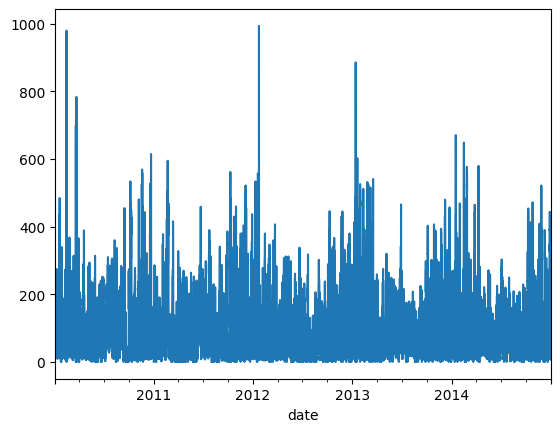

In [21]:
train.index = pd.to_datetime(train['date'], format = '%d-%m-%Y %H:%M')
poll = train['pollution']
poll.plot()

In [22]:
train.wnd_dir.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [23]:
def wind_encode(s):
  if s == "SE":
    return 1
  elif s == "NE":
    return 2
  elif s == "NW":
    return 3
  else:
    return 4

train["wind_dir"] = train["wnd_dir"].apply(wind_encode)
train = train.drop(["wnd_dir", 'date'], axis=1).head()
train.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,wind_dir
date,,,,,,,,
2010-01-02 00:00:00,129,-16,-4.0,1020.0,1.79,0,0,1
2010-01-02 01:00:00,148,-15,-4.0,1020.0,2.68,0,0,1
2010-01-02 02:00:00,159,-11,-5.0,1021.0,3.57,0,0,1
2010-01-02 03:00:00,181,-7,-5.0,1022.0,5.36,1,0,1
2010-01-02 04:00:00,138,-7,-5.0,1022.0,6.25,2,0,1


In [24]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i : i+5]]
    X.append(row)
    label = df_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

WINDOW_SIZE = 5
X, y = df_to_X_y(poll, WINDOW_SIZE)
X.shape, y.shape

((43795, 5, 1), (43795,))

In [25]:
X_train, y_train = X[:35000], y[:35000]
X_val, y_val = X[35000:], y[35000 : 65000]

In [26]:
model = Sequential()
model.add(InputLayer((5,1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss = 'mse', optimizer = Adam(learning_rate=0.001), metrics = [RootMeanSquaredError()])
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, verbose = 1, callbacks = [cp])

Epoch 1/10
1094/1094 [==============================] - 11s 8ms/step - loss: 6435.3257 - root_mean_squared_error: 80.2205 - val_loss: 1810.2744 - val_root_mean_squared_error: 42.5473
Epoch 2/10
1094/1094 [==============================] - 8s 8ms/step - loss: 1223.6605 - root_mean_squared_error: 34.9809 - val_loss: 861.5018 - val_root_mean_squared_error: 29.3514
Epoch 3/10
1094/1094 [==============================] - 8s 7ms/step - loss: 873.1228 - root_mean_squared_error: 29.5487 - val_loss: 724.6489 - val_root_mean_squared_error: 26.9193
Epoch 4/10
1094/1094 [==============================] - 8s 8ms/step - loss: 818.8141 - root_mean_squared_error: 28.6149 - val_loss: 627.5645 - val_root_mean_squared_error: 25.0512
Epoch 5/10
1094/1094 [==============================] - 9s 8ms/step - loss: 791.5463 - root_mean_squared_error: 28.1344 - val_loss: 614.9302 - val_root_mean_squared_error: 24.7978
Epoch 6/10
1094/1094 [==============================] - 9s 8ms/step - loss: 771.3630 - root_mean

In [28]:
model = load_model('model/')
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actual':y_train})
train_results.head()

1094/1094 [==============================] - 3s 2ms/step


,Train Predictions,Actual
0,122.356514,109
1,97.414001,105
2,101.969978,124
3,128.034531,120
4,116.450752,132


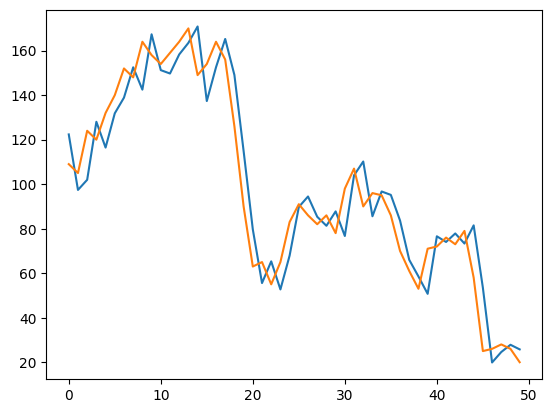

In [29]:
plt.plot(train_results['Train Predictions'][:50])
plt.plot(train_results['Actual'][:50])

In [30]:
val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(data = {'Val Predictions': val_predictions, 'Actual':y_val})
val_results.head()

275/275 [==============================] - 1s 2ms/step


,Val Predictions,Actual
0,25.870440,27
1,26.335815,25
2,23.670973,25
3,24.988033,25
4,25.034483,25


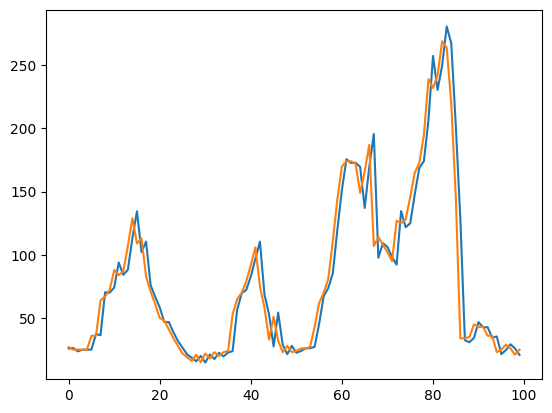

In [31]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actual'][:100])

In [32]:
rmse = np.sqrt(mse(y_val, val_predictions))
print("Validation RMSE =", rmse)

Validation RMSE = 24.330374845413164
